In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

In [5]:
w0vec = [-0.7, -1.0, -1.3]
wavec = [-0.2,0.0,0.2]
#w0vec = [-1.0]
#wavec = [0.0]
 
cosmo = {}
for w0 in w0vec:
    for wa in wavec:
        if w0==-1.0 and wa==0.0:
            M='LCDM'
        else:
            M = '('+str(w0)+','+str(wa)+')'
        cosmo[M] = Class()
        cosmo[M].set({'input_verbose':1,'background_verbose':1,'gauge' : 'Newtonian'})
        if M!='LCDM':
            cosmo[M].set({'Omega_Lambda':0.,'w0_fld':w0,'wa_fld':wa})
        cosmo[M].compute()

Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 13.176241 Gyr
 -> conformal age = 13799.209339 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3405.751108
    corresponding to conformal time = 112.722902 Mpc
Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 13.028458 Gyr
 -> conformal age = 13674.751158 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3405.751108
    corresponding to conformal time = 112.722901 Mpc
Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 12.853929 Gyr
 -> conformal age = 13507.284863 Mpc
 -> N_eff = 3.044 (summed o

In [6]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if '(.)rho_lambda' in bg:
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

In [7]:

bg = cosmo['LCDM'].get_background()

z = bg['z']
a = 1./(z+1)

D_app = bg['gr.fac. D']     #D approssimato
D_ana = D_hypergeom(a,cosmo['LCDM'])    #D analitico


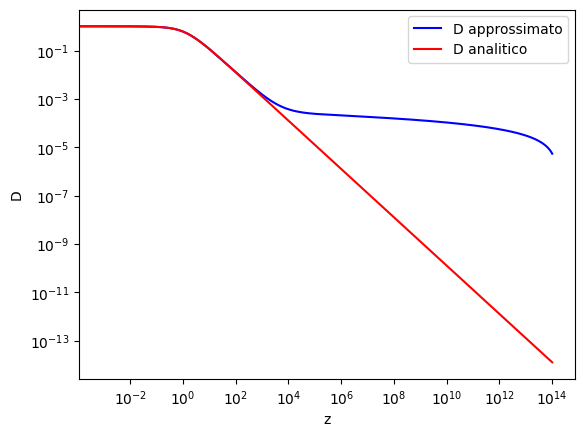

In [8]:
plt.loglog(z, D_app, color='blue', label='D approssimato')
plt.loglog(z, D_ana, color='red', label='D analitico')

plt.xlabel('z')
plt.ylabel('D')

plt.legend()
plt.draw()

**Secondo tentativo**

In [9]:
from classy import Class

In [10]:
M = Class()
cosmo = {'omega_b': 0.02238280, 'omega_cdm': 0.1201075, 'h': 0.67810, 'ln10^{10}A_s': 3.04478383, 'n_s': 0.9660499}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 1})
M.compute()

In [11]:
bg = M.get_background()

z = bg['z']
a = 1./(z+1)

D_app = bg['gr.fac. D']     #D approssimato
D_ana = D_hypergeom(a,M)    #D analitico

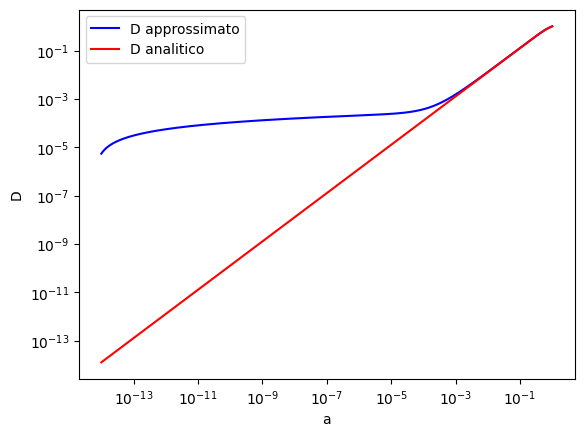

In [13]:
plt.loglog(a, D_app, color='blue', label='D approssimato')
plt.loglog(a, D_ana, color='red', label='D analitico')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.draw()